<a href="https://colab.research.google.com/github/khanhvy31/khanhvy31-BreastCancer_DeepLearning/blob/main/Breast_Cancer_MinMax_CNN_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

## Dataset

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install -q kaggle
from google.colab import files

files.upload()

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
rm: cannot remove '/root/.kaggle': No such file or directory


In [ ]:
!mkdir /content/image
!kaggle datasets download -d theoviel/rsna-breast-cancer-256-pngs -p /content/image
#https://www.kaggle.com/datasets/theoviel/rsna-breast-cancer-256-pngs

 99% 990M/998M [00:09<00:00, 148MB/s]
100% 998M/998M [00:09<00:00, 115MB/s]


In [ ]:
!unzip /content/image/rsna-breast-cancer-256-pngs.zip -d /content/image

Streaming output truncated to the last 5000 lines.
  inflating: /content/image/63617_159110654.png  
  inflating: /content/image/63617_1855699072.png  
  inflating: /content/image/63617_1917877119.png  
  inflating: /content/image/63617_887426674.png  
  inflating: /content/image/63623_1186739164.png  
  inflating: /content/image/63623_1657034655.png  
  inflating: /content/image/63623_335778602.png  
  inflating: /content/image/63623_625719002.png  
  inflating: /content/image/63626_1154699412.png  
  inflating: /content/image/63626_549972940.png  
  inflating: /content/image/63626_599167493.png  
  inflating: /content/image/63626_939566995.png  
  inflating: /content/image/63627_1214214469.png  
  inflating: /content/image/63627_191294190.png  
  inflating: /content/image/63627_669536679.png  
  inflating: /content/image/63627_92618283.png  
  inflating: /content/image/63628_1068923688.png  
  inflating: /content/image/63628_1252453513.png  
  inflating: /content/image/63628_19873236

In [ ]:
#since im lazy
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
cd "/content/drive/MyDrive/Colab Notebooks/UPenn/Spring23/BMIN522/BMIN_Project/Dataset"

/content/drive/MyDrive/Colab Notebooks/UPenn/Spring23/BMIN522/BMIN_Project/Dataset


## Libraries

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
# from efficientnet_pytorch import EfficientNet
from torchvision.transforms import ToTensor
from tqdm import tqdm as tqdm_regular
from torchvision import transforms
from sklearn import preprocessing
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch.optim as optim
from numpy.linalg import *
# import opendatasets as od # only on jupyter
import seaborn as sns
import torch.nn as nn
from PIL import Image
import pandas as pd
import numpy as np
import torchvision
import torch
import sys
import os

## Load dataset

In [ ]:
data = pd.read_csv('train.csv')
# test = pd.read_csv('test.csv')

data_set = data.copy()
# test_set = test.copy()

In [ ]:
# set ROOT to image folder
ROOT = '/content/image'

# set SEED to 42
seed = 42
np.random.seed(42)
torch.manual_seed(42)

Loading cuda 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using:", device)

We're using: cpu


Create a column that has patient_id + _ + image_id to map with image data

In [ ]:
data_set['patient_image_id'] = data_set.apply(lambda row: str(row['patient_id']) + '_' + str(row['image_id']), axis=1)

In [ ]:
data_set.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,patient_image_id
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,10006_462822612
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,10006_1459541791
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,10006_1864590858
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,10006_1874946579
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,10011_220375232


In [ ]:
data_set

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,patient_image_id
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,10006_462822612
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,10006_1459541791
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,10006_1864590858
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,10006_1874946579
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,10011_220375232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54701,1,9973,1729524723,R,MLO,43.0,0,0,0,1.0,0,C,49,False,9973_1729524723
54702,1,9989,63473691,L,MLO,60.0,0,0,0,NaN,0,C,216,False,9989_63473691
54703,1,9989,1078943060,L,CC,60.0,0,0,0,NaN,0,C,216,False,9989_1078943060
54704,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,0,C,216,True,9989_398038886


In [ ]:
cd ../../../../../../../../

/content


In [ ]:
cd image

/content/image


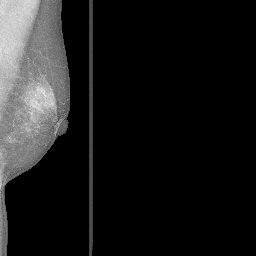

In [ ]:
img = Image.open('10006_1459541791.png')
img

# Exploratory  Data Analysis

## Visualization

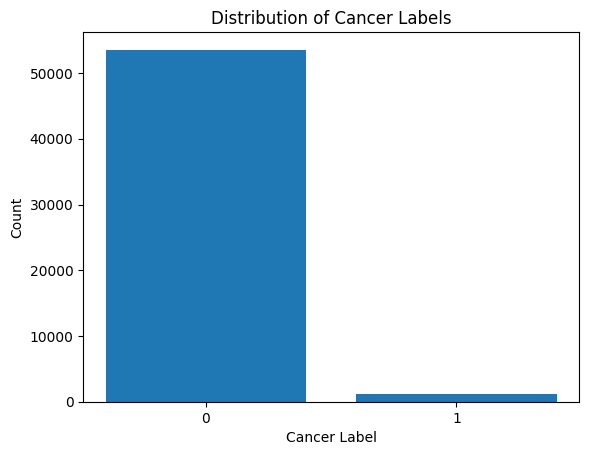

In [ ]:
cancer_counts = data_set['cancer'].value_counts()
plt.bar(cancer_counts.index, cancer_counts.values)

# Set the title and axis labels
plt.title('Distribution of Cancer Labels')
plt.xlabel('Cancer Label')
plt.ylabel('Count')
plt.xticks([0, 1]) # 0 is Not Cancer and 1 is Cancer
plt.show()

In [ ]:
cancer_counts

0    53548
1     1158
Name: cancer, dtype: int64

In [ ]:
53648 / (53548+1158) * 100

98.06602566446094

## Down Sampling

In [ ]:
# Get the indices of rows with cancer = 0 and cancer = 1
cancer_0_idx = data_set[data_set['cancer'] == 0].index
cancer_1_idx = data_set[data_set['cancer'] == 1].index

# Get the number of rows with cancer = 1
n_cancer_1 = len(cancer_1_idx)

# Randomly sample n_cancer_1 rows from the rows with cancer = 0
cancer_0_sampled_idx = np.random.choice(cancer_0_idx, n_cancer_1, replace=False)

# Concatenate the indices of the sampled cancer = 0 rows with the indices of the cancer = 1 rows
selected_idx = np.concatenate([cancer_0_sampled_idx, cancer_1_idx])

# Select the corresponding rows from the dataframe
data_set_selected = data_set.iloc[selected_idx]

data_set_selected['patient_image_id'] = data_set_selected['patient_image_id'] + '.png'

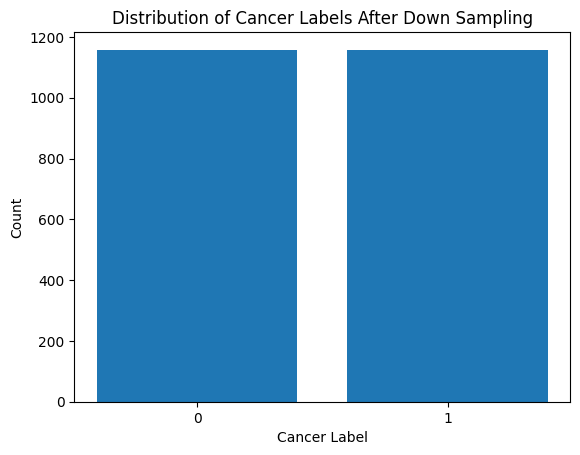

In [ ]:
cancer_counts_selected = data_set_selected['cancer'].value_counts()
plt.bar(cancer_counts_selected.index, cancer_counts_selected.values)

# Set the title and axis labels
plt.title('Distribution of Cancer Labels After Down Sampling')
plt.xlabel('Cancer Label')
plt.ylabel('Count')
plt.xticks([0, 1]) # 0 is Not Cancer and 1 is Cancer
plt.show()

In [ ]:
cancer_counts_selected

0    1158
1    1158
Name: cancer, dtype: int64

## Split 

In [ ]:
train_df, test_df = train_test_split(data_set_selected, \
                                     test_size=0.2, \
                                     stratify=data_set_selected['cancer'], \
                                     random_state=42)

In [ ]:
train_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,patient_image_id
35664,2,48230,386832097,R,MLO,68.0,1,1,1,NaN,0,NaN,21,False,48230_386832097.png
24170,1,35847,2041771555,R,CC,74.0,1,1,1,0.0,0,B,49,False,35847_2041771555.png
1667,2,1179,399222572,R,CC,66.0,0,0,0,0.0,0,NaN,29,True,1179_399222572.png
16748,2,27742,477303167,R,CC,67.0,0,0,0,NaN,0,NaN,48,False,27742_477303167.png
52403,1,7412,433654574,R,CC,78.0,0,0,0,2.0,0,B,49,False,7412_433654574.png


In [ ]:
train_df

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,patient_image_id
35664,2,48230,386832097,R,MLO,68.0,1,1,1,NaN,0,NaN,21,False,48230_386832097.png
24170,1,35847,2041771555,R,CC,74.0,1,1,1,0.0,0,B,49,False,35847_2041771555.png
1667,2,1179,399222572,R,CC,66.0,0,0,0,0.0,0,NaN,29,True,1179_399222572.png
16748,2,27742,477303167,R,CC,67.0,0,0,0,NaN,0,NaN,48,False,27742_477303167.png
52403,1,7412,433654574,R,CC,78.0,0,0,0,2.0,0,B,49,False,7412_433654574.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44024,1,57525,550007476,R,MLO,67.0,1,1,1,0.0,0,A,49,False,57525_550007476.png
18818,1,29890,167807018,R,MLO,49.0,0,0,0,0.0,0,B,49,True,29890_167807018.png
571,1,10589,1967460233,L,CC,74.0,1,1,1,0.0,0,B,170,False,10589_1967460233.png
33921,1,46399,1232620699,L,MLO,67.0,0,0,0,2.0,0,A,49,False,46399_1232620699.png


In [ ]:
test_df

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,patient_image_id
39721,1,52961,960650011,L,MLO,60.0,0,0,0,NaN,0,C,49,False,52961_960650011.png
30035,1,42079,1634891014,L,MLO,76.0,0,0,0,1.0,0,A,49,False,42079_1634891014.png
27107,2,38946,1288050525,R,CC,64.0,1,1,1,NaN,0,NaN,29,False,38946_1288050525.png
24169,1,35847,1069414688,R,MLO,74.0,1,1,1,0.0,0,B,49,False,35847_1069414688.png
34435,2,4696,1846316095,L,CC,71.0,1,1,1,NaN,0,NaN,48,False,4696_1846316095.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8991,1,1963,2090715578,L,MLO,67.0,1,1,1,0.0,0,B,49,False,1963_2090715578.png
2594,2,12728,1315445761,R,MLO,59.0,0,0,0,NaN,0,NaN,48,False,12728_1315445761.png
35782,2,48350,1102444861,R,MLO,61.0,1,1,1,NaN,0,NaN,21,False,48350_1102444861.png
610,2,10638,311168378,L,MLO,63.0,1,1,1,NaN,0,NaN,21,False,10638_311168378.png


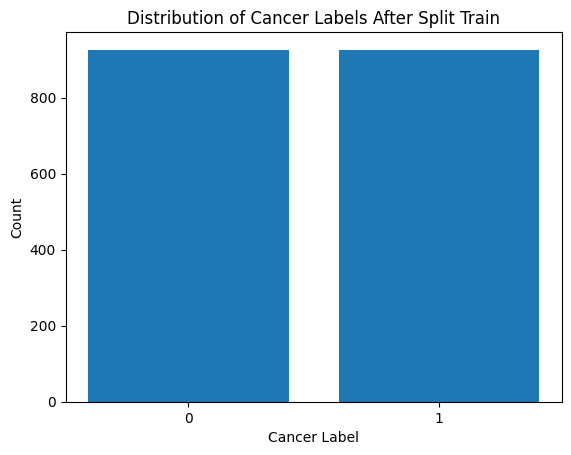

In [ ]:
train_df_selected = train_df['cancer'].value_counts()
plt.bar(train_df_selected.index, train_df_selected.values)

# Set the title and axis labels
plt.title('Distribution of Cancer Labels After Split Train')
plt.xlabel('Cancer Label')
plt.ylabel('Count')
plt.xticks([0, 1]) # 0 is Not Cancer and 1 is Cancer
plt.show()

In [ ]:
train_df_selected

1    926
0    926
Name: cancer, dtype: int64

## Match Labels

In [ ]:
endcoding_to_label = {0: "Non Cancer",
                      1: "Cancer"}

image_labels_train = dict(zip(train_df['patient_image_id'], train_df['cancer']))
image_labels_test = dict(zip(test_df['patient_image_id'], test_df['cancer']))

In [ ]:
print("Train label matched")
for key, value in list(image_labels_train.items())[:4]:
    print(key, " : ", value)

Train label matched
48230_386832097.png  :  1
35847_2041771555.png  :  1
1179_399222572.png  :  0
27742_477303167.png  :  0


In [ ]:
print("Test label matched")
for key, value in list(image_labels_test.items())[:4]:
    print(key, " : ", value)

Test label matched
52961_960650011.png  :  0
42079_1634891014.png  :  0
38946_1288050525.png  :  1
35847_1069414688.png  :  1


In [ ]:
list(image_labels_test.keys())[1]

'42079_1634891014.png'

In [ ]:
class breastCancerDataset(Dataset):
  def __init__(self, labels_dict, transform=None):
    # self.image_path = image_path
    self.labels_dict = labels_dict
    self.filenames = list(labels_dict.keys())
    self.transform = transform

  def __len__(self):
    return len(self.labels_dict)

  def __getitem__(self, idx):
    
    img_name = self.filenames[idx]
    label = list(self.labels_dict.values())[idx]
    img = Image.open(img_name)

    if self.transform:
      img = self.transform(img)
    
    return img, label

In [ ]:
train_dataset = breastCancerDataset(labels_dict=image_labels_train)
test_dataset = breastCancerDataset(labels_dict=image_labels_test)

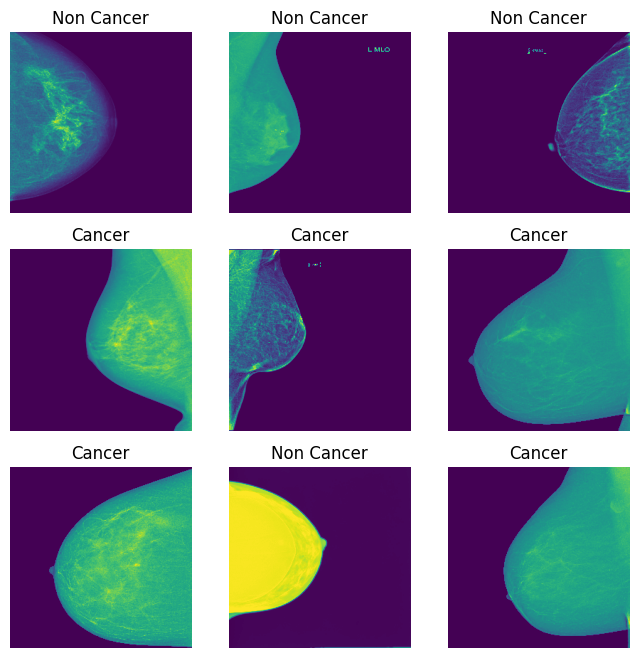

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
torch.manual_seed(0)
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(endcoding_to_label[label])
    plt.axis("off")
    plt.imshow(img)
plt.show()

# Feature Engineering (Min Max)


## Min Max

In [ ]:
class MinMaxTransform:
    def __init__(self, min_val, max_val):
        self.min_val = min_val
        self.max_val = max_val

    def __call__(self, x):
        x = (x - self.min_val) / (self.max_val - self.min_val)
        return x

In [ ]:
min_val = 0  # minimum pixel value
max_val = 255  # maximum pixel value

transform = transforms.Compose([transforms.ToTensor(),
                                MinMaxTransform(min_val, max_val),
                                ])

In [ ]:
train_dataset = breastCancerDataset(labels_dict=image_labels_train,transform = transform)
test_dataset = breastCancerDataset(labels_dict=image_labels_test,transform = transform)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Modeling (Min Max)

We will be building CNN and ResNet 101 to train and test our RSNA Breast Cancer data

## CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 16 * 16, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.relu5 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        
        self.fc2 = nn.Linear(512, 256)
        self.bn6 = nn.BatchNorm1d(256)
        self.relu6 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.5)

        self.fc3 = nn.Linear(256, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pool4(x)
        
        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc1(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn6(x)
        x = self.relu6(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.sigmoid(x)
        
        return x
    # def forward(self, xb):
    #     return self.network(xb)

model = CNN().to(device)

In [ ]:
# 1. Set the criterion to be cross entropy loss
criterion = nn.CrossEntropyLoss()

# 2. Experiment with different optimizers
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loss= []
test_loss = []
train_acc = []
test_acc = []

train_acc_plt = []
test_acc_plt = []

In [ ]:
num_epochs = 35

for epoch in range(num_epochs):
    model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_dataloader)
    train_acc = correct / total
    train_acc_plt.append(train_acc)
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.4f' %
          (epoch + 1, train_loss, train_acc))

    # Test the model
    model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = running_loss / len(test_dataloader)
    test_acc = correct / total
    test_acc_plt.append(test_acc)
    print('Test Accuracy: %.4f' % (test_acc))


Epoch: 1 | Loss: 0.6989 | Train Accuracy: 0.5032
Test Accuracy: 0.5000
Epoch: 2 | Loss: 0.6795 | Train Accuracy: 0.5599
Test Accuracy: 0.5000
Epoch: 3 | Loss: 0.6705 | Train Accuracy: 0.5907
Test Accuracy: 0.4914
Epoch: 4 | Loss: 0.6591 | Train Accuracy: 0.5988
Test Accuracy: 0.5711
Epoch: 5 | Loss: 0.6538 | Train Accuracy: 0.6118
Test Accuracy: 0.5366
Epoch: 6 | Loss: 0.6338 | Train Accuracy: 0.6539
Test Accuracy: 0.5000
Epoch: 7 | Loss: 0.6216 | Train Accuracy: 0.6609
Test Accuracy: 0.5000
Epoch: 8 | Loss: 0.6028 | Train Accuracy: 0.6938
Test Accuracy: 0.5000
Epoch: 9 | Loss: 0.5797 | Train Accuracy: 0.7106
Test Accuracy: 0.5172
Epoch: 10 | Loss: 0.5573 | Train Accuracy: 0.7435
Test Accuracy: 0.5000
Epoch: 11 | Loss: 0.5342 | Train Accuracy: 0.7727
Test Accuracy: 0.5000
Epoch: 12 | Loss: 0.5287 | Train Accuracy: 0.7759
Test Accuracy: 0.5539
Epoch: 13 | Loss: 0.4934 | Train Accuracy: 0.8207
Test Accuracy: 0.4957
Epoch: 14 | Loss: 0.4786 | Train Accuracy: 0.8278
Test Accuracy: 0.5000
E

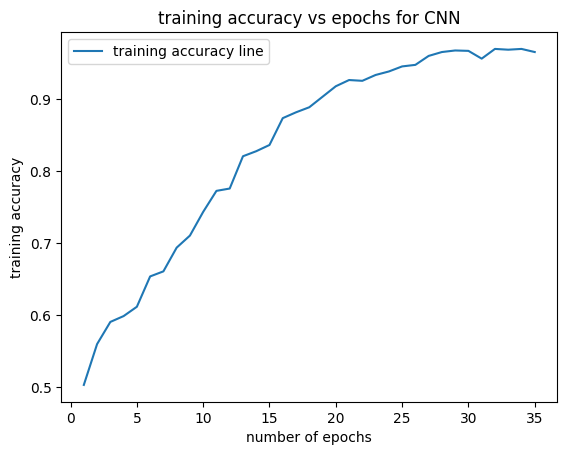

In [ ]:
# TODO
y = train_acc_plt
x = np.arange(1,36)
plt.plot(x,y,label='training accuracy line')
plt.title("training accuracy vs epochs for CNN")
plt.xlabel("number of epochs")
plt.ylabel("training accuracy")
plt.legend()
# END TODO 

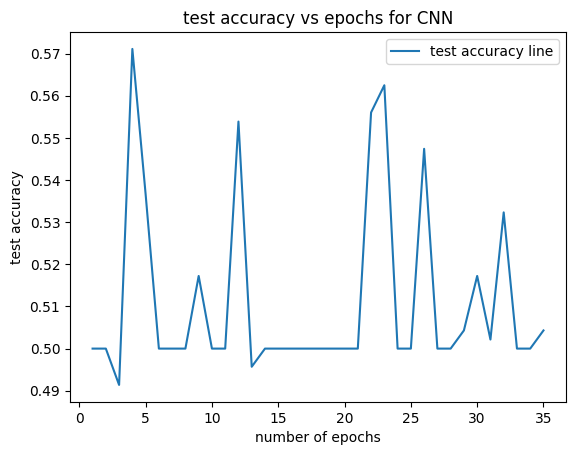

In [ ]:
# TODO
y = test_acc_plt
x = np.arange(1,36)
plt.plot(x,y,label='test accuracy line')
plt.title("test accuracy vs epochs for CNN")
plt.xlabel("number of epochs")
plt.ylabel("test accuracy")
plt.legend()
# END TODO 

## ResNet-101

In [ ]:
model = torchvision.models.resnet101(pretrained=False)

# Modify the first convolutional layer to accept a single channel input
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
train_loss= []
test_loss = []
train_acc = []
test_acc = []

train_acc_plt_res101 = []
test_acc_plt_res101 = []

In [ ]:
num_epochs = 35

for epoch in range(num_epochs):
    model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_dataloader)
    train_acc = correct / total
    train_acc_plt_res101.append(train_acc)
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.4f' %
          (epoch + 1, train_loss, train_acc))

    # Test the model
    model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = running_loss / len(test_dataloader)
    test_acc = correct / total
    test_acc_plt_res101.append(test_acc)
    print('Test Accuracy: %.4f' % (test_acc))


Epoch: 1 | Loss: 0.9091 | Train Accuracy: 0.5016
Test Accuracy: 0.4569
Epoch: 2 | Loss: 0.7099 | Train Accuracy: 0.5367
Test Accuracy: 0.5000
Epoch: 3 | Loss: 0.7049 | Train Accuracy: 0.5448
Test Accuracy: 0.5474
Epoch: 4 | Loss: 0.7087 | Train Accuracy: 0.5297
Test Accuracy: 0.5474
Epoch: 5 | Loss: 0.7108 | Train Accuracy: 0.5529
Test Accuracy: 0.5582
Epoch: 6 | Loss: 0.6987 | Train Accuracy: 0.5486
Test Accuracy: 0.5776
Epoch: 7 | Loss: 0.6800 | Train Accuracy: 0.5610
Test Accuracy: 0.5216
Epoch: 8 | Loss: 0.6815 | Train Accuracy: 0.5799
Test Accuracy: 0.5409
Epoch: 9 | Loss: 0.6778 | Train Accuracy: 0.5842
Test Accuracy: 0.5862
Epoch: 10 | Loss: 0.6716 | Train Accuracy: 0.5783
Test Accuracy: 0.5690
Epoch: 11 | Loss: 0.6623 | Train Accuracy: 0.5967
Test Accuracy: 0.5539
Epoch: 12 | Loss: 0.6628 | Train Accuracy: 0.5918
Test Accuracy: 0.5582
Epoch: 13 | Loss: 0.6535 | Train Accuracy: 0.6145
Test Accuracy: 0.5776
Epoch: 14 | Loss: 0.6753 | Train Accuracy: 0.5875
Test Accuracy: 0.5647
E

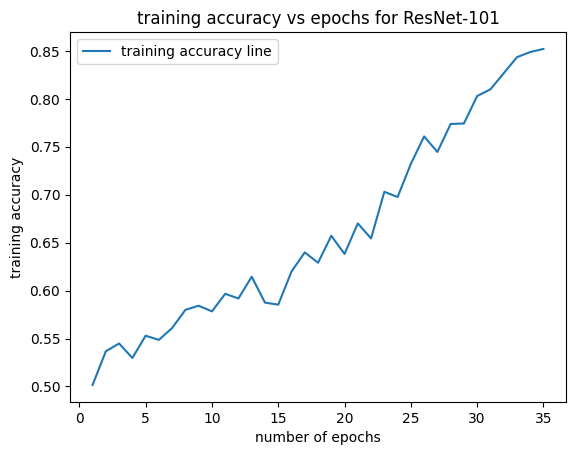

In [ ]:
y = train_acc_plt_res101
x = np.arange(1,36)
plt.plot(x,y,label='training accuracy line')
plt.title("training accuracy vs epochs for ResNet-101")
plt.xlabel("number of epochs")
plt.ylabel("training accuracy")
plt.legend()

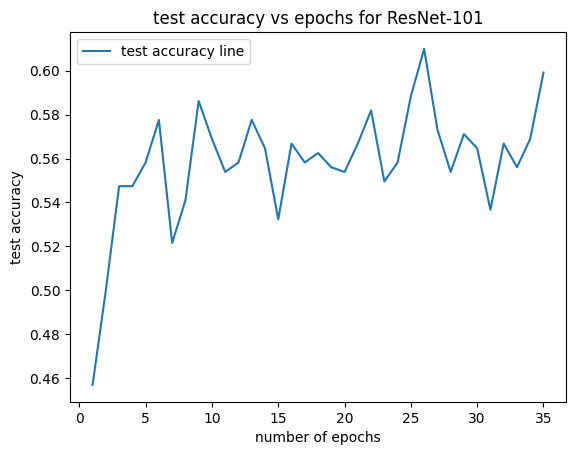

In [ ]:
y = test_acc_plt_res101
x = np.arange(1,36)
plt.plot(x,y,label='test accuracy line')
plt.title("test accuracy vs epochs for ResNet-101")
plt.xlabel("number of epochs")
plt.ylabel("test accuracy")
plt.legend()